<h1><center> SI 671 Final Project: Spotify Similarity</center></h1>


    
<center>Name: Lauren Lunsford</center>

<center>Start Date: November 14, 2021</center>

### Workflow Plan

**Preprocessing** 
- Reading in the data
- Changing the time listened to into a date/time
- Converting the length of time listening to an audio item from milliseconds to mins or seconds  
- Creating unique track ID by combining artist and track

**EDA** 
- Analyze data distribution 
- Perform analyses similar to Yizhack and Buentello to familiarize myself with the data

**Analysis** 
- Build similarity functions that compare the similarity of subsets of listening data which would include ordered lists of audio items listened to
- I hope to use these similarity metrics to compare my intuitions about which friends I’m most similar to, with the similarity metrics.
- I will note these insights in a brief document overview of the script and it’s capabilities.

**Script**
- Construct a python script that utilizes user input functions to let users choose how to analyse their data. 


## 1. Preprocessing

In [50]:
import os
import pandas as pd
import seaborn as sns
import matplotlib as plt
import numpy as np
import pytz
import math
import networkx as nx
import requests
import json
import urllib
import time
from concurrent.futures import ThreadPoolExecutor


#### A. Reading in Data

In [51]:
def read_data(folder):
    '''
    input: function takes in a users folder name 
    
    output: a dataframe containing all streaming history
    '''
    directory = f'data/{folder}'
    dfs=[] 
    for file_name in os.listdir(directory):  #each streamer has a different number of streaming data files 
        if 'StreamingHistory' in file_name:
            dfs.append(pd.read_json(directory+'/'+file_name))
    return pd.concat(dfs)
    

In [52]:
df=read_data('f1')
df.head()

,endTime,artistName,trackName,msPlayed
0,2021-07-18 06:52,Swim Mountain,Yesterday,210625
1,2021-07-18 06:52,Benji Hughes,Freaky Feedback Blues,15840
2,2021-07-19 12:46,Benji Hughes,Freaky Feedback Blues,26819
3,2021-07-19 12:52,Biz Markie,Vapors,362293
4,2021-07-19 12:52,Bahamas,Alone,6403


#### B. Changing Time Zone
Data is in UTC time, I am changing it to US Detroit time. 

In [53]:
def change_timezone_to_detroit(df):
    df['UTC']=pd.to_datetime(df['endTime'])
    df['endTime']=pd.to_datetime(df['endTime'])

    #localizing endTime to UTC Time
    local_tz = pytz.timezone('UTC') # setting time zone ot UTC 
    df['endTime']= df['endTime'].apply(lambda x: local_tz.localize(x))
    
    #changing timezones to detroit
    EST= pytz.timezone('America/Detroit')
    df['endTime']=df['endTime'].apply(lambda x: EST.normalize(x))
    
    return df

In [54]:
change_timezone_to_detroit(df).head()

,endTime,artistName,trackName,msPlayed,UTC
0,2021-07-18 02:52:00-04:00,Swim Mountain,Yesterday,210625,2021-07-18 06:52:00
1,2021-07-18 02:52:00-04:00,Benji Hughes,Freaky Feedback Blues,15840,2021-07-18 06:52:00
2,2021-07-19 08:46:00-04:00,Benji Hughes,Freaky Feedback Blues,26819,2021-07-19 12:46:00
3,2021-07-19 08:52:00-04:00,Biz Markie,Vapors,362293,2021-07-19 12:52:00
4,2021-07-19 08:52:00-04:00,Bahamas,Alone,6403,2021-07-19 12:52:00


#### C. Ms To Min
Adding a minutes column to better grasp consumption

In [55]:
def get_mins_listened(df):
    df['minsPlayed']=df['msPlayed']/60000
    return df

In [56]:
get_mins_listened(df).head()

,endTime,artistName,trackName,msPlayed,UTC,minsPlayed
0,2021-07-18 02:52:00-04:00,Swim Mountain,Yesterday,210625,2021-07-18 06:52:00,3.510417
1,2021-07-18 02:52:00-04:00,Benji Hughes,Freaky Feedback Blues,15840,2021-07-18 06:52:00,0.264000
2,2021-07-19 08:46:00-04:00,Benji Hughes,Freaky Feedback Blues,26819,2021-07-19 12:46:00,0.446983
3,2021-07-19 08:52:00-04:00,Biz Markie,Vapors,362293,2021-07-19 12:52:00,6.038217
4,2021-07-19 08:52:00-04:00,Bahamas,Alone,6403,2021-07-19 12:52:00,0.106717


#### D. Creating unique track ID
Adding a minutes column to better understand 

In [57]:
def get_track_id(df):
    df['trackID']=df['trackName']+'--'+df['artistName']
    return df

In [58]:
get_track_id(df).head()

,endTime,artistName,trackName,msPlayed,UTC,minsPlayed,trackID
0,2021-07-18 02:52:00-04:00,Swim Mountain,Yesterday,210625,2021-07-18 06:52:00,3.510417,Yesterday--Swim Mountain
1,2021-07-18 02:52:00-04:00,Benji Hughes,Freaky Feedback Blues,15840,2021-07-18 06:52:00,0.264000,Freaky Feedback Blues--Benji Hughes
2,2021-07-19 08:46:00-04:00,Benji Hughes,Freaky Feedback Blues,26819,2021-07-19 12:46:00,0.446983,Freaky Feedback Blues--Benji Hughes
3,2021-07-19 08:52:00-04:00,Biz Markie,Vapors,362293,2021-07-19 12:52:00,6.038217,Vapors--Biz Markie
4,2021-07-19 08:52:00-04:00,Bahamas,Alone,6403,2021-07-19 12:52:00,0.106717,Alone--Bahamas


#### E. Dropping Briefly Listened Songs


<AxesSubplot:>

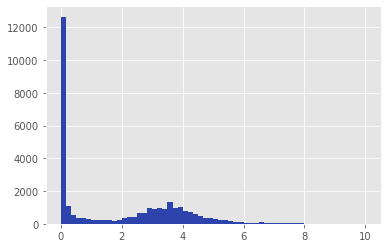

In [59]:
df['minsPlayed'].hist(bins=60, range=(0, 10), color='#2c44ac',)

It looks like there's a bunch of songs that are skipped over. For our analysis, we dont want to consider those songs. We're going to make the cutoff 30 seconds.

In [60]:
def drop_skipped_songs(df):
    df=df[df['minsPlayed']>0.5]
    return df

<AxesSubplot:>

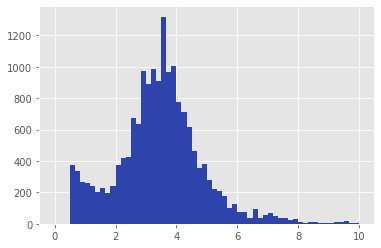

In [61]:
drop_skipped_songs(df)['minsPlayed'].hist(bins=60, range=(0, 10), color='#2c44ac')

### F. Total Preprocess Script

In [62]:
def preprocess(name):
    df=read_data(name)
    df=change_timezone_to_detroit(df)
    df=get_mins_listened(df)
    df=get_track_id(df)
    df=drop_skipped_songs(df)
    return df

In [63]:
f1=preprocess('f1')
f3=preprocess('f3')
f2=preprocess('f2')
user=preprocess('user')
f4=preprocess('f4')

In [64]:
def preprocess_nd(name):
    df=read_data(name)
    df=change_timezone_to_detroit(df)
    df=get_mins_listened(df)
    df=get_track_id(df)
    return df

In [65]:
f1_nd=preprocess_nd('f1')
f3_nd=preprocess_nd('f3')
f2_nd=preprocess_nd('f2')
user_nd=preprocess_nd('user')


In [66]:
losses=[]
losses.append((f1_nd.shape[0]- f1.shape[0])/f1_nd.shape[0] )
losses.append((user_nd.shape[0]- user.shape[0])/user_nd.shape[0] )
losses.append((f2.shape[0]- f2.shape[0])/f2_nd.shape[0] )
losses.append((f3.shape[0]- f3.shape[0])/f3_nd.shape[0] )
np.mean(losses)

0.20593882828141927

In [67]:
sum(f1_nd['minsPlayed'])

61797.67770000017

In [68]:
losses=[]
losses.append((sum(f1_nd['minsPlayed'])- sum(f1['minsPlayed']))/sum(f1_nd['minsPlayed']) )
losses.append((sum(user_nd['minsPlayed'])- sum(user['minsPlayed']))/sum(user_nd['minsPlayed']) )
losses.append((sum(f3_nd['minsPlayed'])- sum(f3['minsPlayed']))/sum(f3_nd['minsPlayed']) )
losses.append((sum(f2_nd['minsPlayed'])- sum(f2['minsPlayed']))/sum(f2_nd['minsPlayed']) )

np.mean(losses)

0.010323354676716405

In [69]:
f2


,endTime,artistName,trackName,msPlayed,UTC,minsPlayed,trackID
0,2020-11-29 12:46:00-05:00,Masashi Hamauzu,Nautilus,209337,2020-11-29 17:46:00,3.488950,Nautilus--Masashi Hamauzu
1,2020-11-29 12:48:00-05:00,Tenno,Lone Wanderer,181000,2020-11-29 17:48:00,3.016667,Lone Wanderer--Tenno
2,2020-11-29 12:53:00-05:00,Matheus Maignardi,Baku in Your Nightmares,303144,2020-11-29 17:53:00,5.052400,Baku in Your Nightmares--Matheus Maignardi
3,2020-11-29 12:57:00-05:00,Lords Of The Underground,Chief Rocka,247400,2020-11-29 17:57:00,4.123333,Chief Rocka--Lords Of The Underground
4,2020-11-29 13:01:00-05:00,Paul Wall,Ridin' 5,192261,2020-11-29 18:01:00,3.204350,Ridin' 5--Paul Wall
...,...,...,...,...,...,...,...
7753,2021-11-29 11:23:00-05:00,Sam Smith,Nothing Left For You,226731,2021-11-29 16:23:00,3.778850,Nothing Left For You--Sam Smith
7754,2021-11-29 11:27:00-05:00,Sam Smith,The Thrill Of It All,208903,2021-11-29 16:27:00,3.481717,The Thrill Of It All--Sam Smith
7755,2021-11-29 11:30:00-05:00,Sam Smith,Scars,183535,2021-11-29 16:30:00,3.058917,Scars--Sam Smith
7756,2021-11-29 11:33:00-05:00,Sam Smith,One Day At A Time,209380,2021-11-29 16:33:00,3.489667,One Day At A Time--Sam Smith


## 2. Early Data Analysis


### A. Time of Day Listening

In [70]:
import matplotlib.pyplot as plt

In [71]:
def plot_time_of_day_streams(df, name):
    plt.style.use('ggplot')

    #x_pos = [i for i, _ in enumerate(x)]

    plt.hist(df['endTime'].map(lambda x: x.hour), color='skyblue')
    plt.xlabel("Hour")
    plt.ylabel("# Of Songs Played")
    plt.title(f"{name}")

    plt.show()

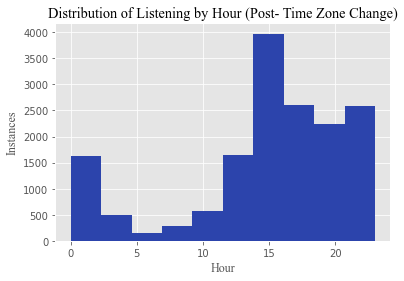

In [72]:
import matplotlib.pyplot as plt
fig = plt.figure()
#ax.bar(users,students)
csfont = {'fontname':'Times New Roman'}

plt.hist(user['endTime'].map(lambda x: x.hour), color='#2c44ac')

plt.title('Distribution of Listening by Hour (Post- Time Zone Change)',**csfont)
plt.xlabel("Hour", **csfont)
plt.ylabel('Instances',**csfont)


plt.show()

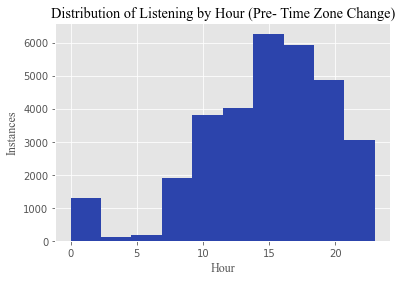

In [73]:
import matplotlib.pyplot as plt
fig = plt.figure()
#ax.bar(users,students)
csfont = {'fontname':'Times New Roman'}

plt.hist(df['endTime'].map(lambda x: x.hour), color='#2c44ac')

plt.title('Distribution of Listening by Hour (Pre- Time Zone Change)',**csfont)
plt.xlabel("Hour", **csfont)
plt.ylabel('Instances',**csfont)


plt.show()

In [74]:
df=read_data('user')
df=get_mins_listened(df)
df=get_track_id(df)
df['endTime']=pd.to_datetime(df['endTime'])
    

### B. Day of The Week Listening

import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')

x = [ 'Monday', 'Tuesday', 'Wednesday','Thursday','Friday','Saturday','Sunday']
hrs = list(day_of_week['msPlayed']/1000/60/60/52) #divide by 52 to get average bc that's num instances of each day in yr (appx)

x_pos = [i for i, _ in enumerate(x)]
plt.axes([0, 0.6, 1.5, 1])

plt.bar(x_pos, hrs, color='skyblue')
plt.xlabel("Day of Week")
plt.ylabel("Average Time Played (in hours)")
plt.title("Average Listening Times by Day of Week")

plt.xticks(x_pos, x)

plt.show()

### C. Distribution of Artists by Listening Time

In [75]:
def get_top_artists(df):
    top_artists=df.groupby('artistName').sum()
    top_artists=top_artists.sort_values(by=['minsPlayed'],ascending=False)
    top_artists=top_artists.reset_index()
    top_artists=top_artists.drop(columns=['msPlayed'])
    return top_artists

array([[<AxesSubplot:title={'center':'minsPlayed'}>]], dtype=object)

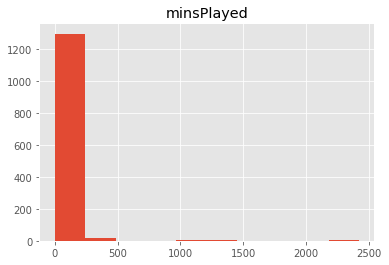

In [76]:
get_top_artists(f3).hist()

### D. Distribution of Songs by Listening Time

In [77]:
def get_top_songs(df):
    top_songs=df.groupby('trackID').sum()
    top_songs=top_songs.sort_values(by=['minsPlayed'],ascending=False)
    top_songs=top_songs.reset_index()
    top_songs=top_songs.drop(columns=['msPlayed'])
    return top_songs

array([[<AxesSubplot:title={'center':'minsPlayed'}>]], dtype=object)

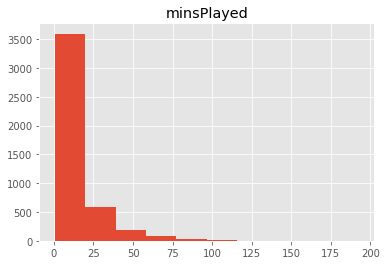

In [78]:
get_top_songs(f1).hist()

## 3. Individual Analysis

### A. Support Analysis

#### i. preprocess for this analysis

In [79]:
def get_itemsets(df):
    df['day']=df['endTime'].apply(lambda x: str(x.year) + '-'+ str(x.month)+'-' + str(x.day) )
    track_itemset={}
    artist_itemset={}
    for row in df.values:
        day=row[-1]
        trackID=row[6]
        artist=row[1]
        if day in track_itemset:
            track_itemset[day].append(trackID)
        else:
            track_itemset[day]= [trackID]
        if day in artist_itemset:
            artist_itemset[day].append(artist)
        else:
            artist_itemset[day]= [artist]
    return track_itemset, artist_itemset


In [80]:
def get_similarity_matrix(dictionary):
    #format it for binarizer
    rows=[]
    for key in dictionary.keys():
        rows.append(dictionary[key])
    
    from sklearn.preprocessing import MultiLabelBinarizer
    mlb = MultiLabelBinarizer()
    matrix=mlb.fit_transform(rows)
    
    labels=list(mlb.classes_)
    return matrix, labels
        

In [81]:
def frequent_itemsets(matrix, k, min_support, labels):
    from mlxtend.frequent_patterns import apriori
    import pandas as pd
    from mlxtend.preprocessing import TransactionEncoder
    
    #transforming matrix into necessary format for apriori
    def tf(x):
        if x==1:
            x=True
        if x==0:
            x=False
        return x

    import pandas as pd
    from mlxtend.preprocessing import TransactionEncoder
    
    df=pd.DataFrame(matrix, columns=labels)
    df=df.applymap(lambda x: tf(x))
    
    aprior=apriori(df, min_support=min_support)
    output= aprior[k>=aprior['itemsets'].apply(lambda x:len(x))]
    
    return output


In [82]:
def interpret_itemsets(results, labels):
    def translate(x, labels):
        items=list(x)
        results=[]
        for item in items:
            results.append(labels[int(item)])
        return results
    results['itemsets']=results['itemsets'].apply(lambda x: translate(x, labels))
    return results

In [83]:
def perform_itemset_similarity(df, similarity, kind='artist'):
    if kind == 'artist':
        dictionary=get_itemsets(df)[1]
    if kind == 'song'or kind =='track':
        dictionary=get_itemsets(df)[0]
    preprocessed=get_similarity_matrix(dictionary)
    matrix=preprocessed[0]
    labels=preprocessed[1]
    results=frequent_itemsets(matrix, 2, similarity, labels)
    interpreted_results=interpret_itemsets(results, labels)
    return   interpreted_results  


In [84]:
perform_itemset_similarity(user, .09, kind='artist')

,support,itemsets
0,0.102639,[A Tribe Called Quest]
1,0.117302,[Alabama Shakes]
2,0.099707,[Amy Winehouse]
3,0.093842,[Andie]
4,0.193548,[Babe Rainbow]
5,0.111437,[Brad Goodall]
6,0.114370,[Brittany Howard]
7,0.102639,[Ella Fitzgerald]
8,0.129032,[Good Morning]
9,0.090909,[Heartless Bastards]


### B. Artist & Song Networks

In [85]:
def get_network_data(similarity_df):
    return [x for x in similarity_df['itemsets'].values if len(x)==2]

In [86]:
def make_artist_network(network_edges):
    import matplotlib.pyplot as plt
    import networkx as nx
    G=nx.Graph()
    for edge in network_edges:
        G.add_edge(edge[0],edge[1])
    plt.figure(3,figsize=(10,10)) 
    nx.drawing.nx_pylab.draw_networkx(G, font_size=8, edge_color='lightgrey', node_color='grey')
    plt.show()
    return G
    

In [87]:
def perform_network_analysis(df, similarity, kind='artist' ):
    sim=perform_itemset_similarity(df, similarity, kind=kind)
    data=get_network_data(sim)
    return make_artist_network(data)

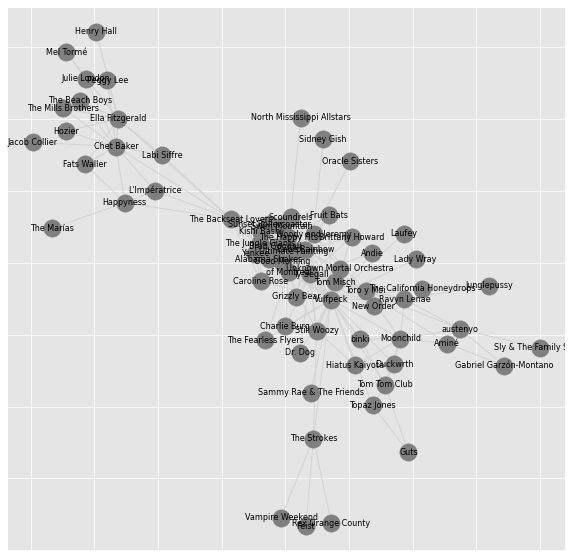

In [88]:
user_graph=perform_network_analysis(user, .04)

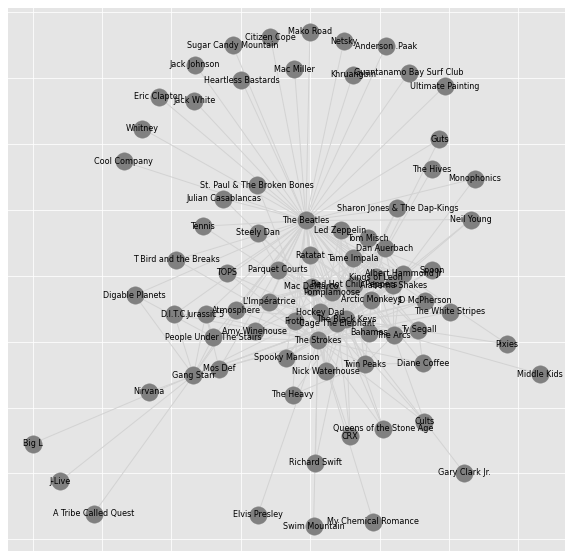

In [89]:
f1_graph=perform_network_analysis(f1, .04)

#test

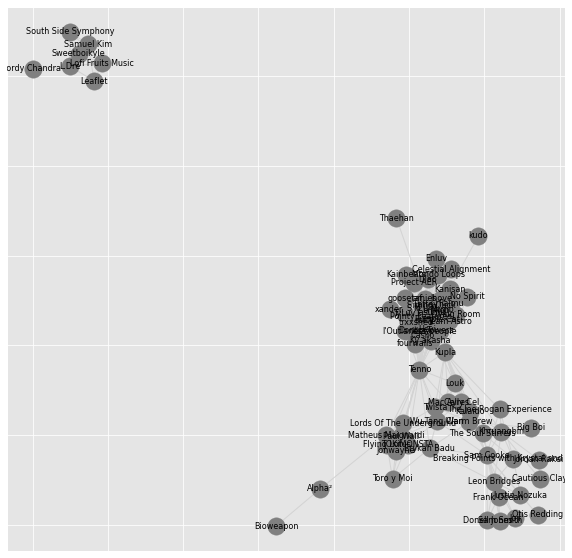

In [92]:
f2_graph=perform_network_analysis(f2, .04)

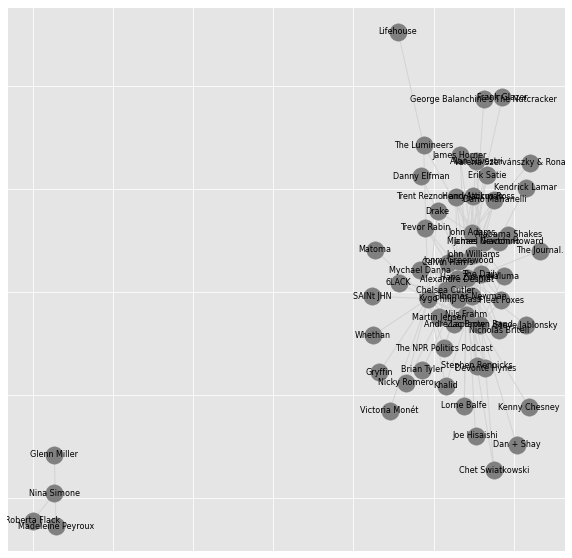

In [93]:
f3_graph=perform_network_analysis(f3, .04)

## 4. Paired Analysis

### A. Find similar top artists

Goal: find 10 top common artists 

In [94]:
def lowest_val(x):
    if x['minsPlayeddf1'] >x['minsPlayeddf2']:
        return x['minsPlayeddf2']
    else:
        return x['minsPlayeddf1']

In [95]:
def top_similar_artists(df1, df2):
    top1=get_top_artists(df1)
    top2=get_top_artists(df2)
    top_common_artists=top1.merge(top2, how='inner', on='artistName', suffixes=('df1', 'df2'))
    top_common_artists['lowestCommonMinsPlayed']=top_common_artists.apply(lowest_val, axis=1)
    top_common_artists=top_common_artists.sort_values(by=['lowestCommonMinsPlayed'],ascending=False)
    return top_common_artists

In [96]:
user_f1=top_similar_artists(user, f1).head(10)
user_f1.rename(columns={'artistName':'artist', 'minsPlayeddf1':'PrimaryUserMinsPlayed','minsPlayeddf2' :'Friend1MinsPlayed', 'lowestCommonMinsPlayed': 'CommonMinsPlayed'})


,artist,PrimaryUserMinsPlayed,Friend1MinsPlayed,CommonMinsPlayed
8,Tom Misch,312.346817,318.235900,312.346817
15,Alabama Shakes,249.688817,381.953817,249.688817
20,The Strokes,231.508250,593.930867,231.508250
5,Ty Segall,361.670050,168.129883,168.129883
28,Andie,161.231033,165.350717,161.231033
24,Amy Winehouse,192.594417,146.124617,146.124617
39,Neil Young,149.422667,141.153517,141.153517
14,Ultimate Painting,250.004700,129.183650,129.183650
49,Parquet Courts,126.913683,375.973383,126.913683
53,Anderson .Paak,117.721750,144.574467,117.721750


In [97]:
user_f3=top_similar_artists(user, f3).head(10)
user_f3.rename(columns={'artistName':'artist', 'minsPlayeddf1':'PrimaryUserMinsPlayed','minsPlayeddf2' :'Friend3MinsPlayed', 'lowestCommonMinsPlayed': 'CommonMinsPlayed'})


,artist,PrimaryUserMinsPlayed,Friend3MinsPlayed,CommonMinsPlayed
7,Alabama Shakes,249.688817,354.632083,249.688817
22,Anderson .Paak,117.721750,73.072433,73.072433
21,The Internet,122.761650,72.941950,72.941950
2,Ella Fitzgerald,312.950400,67.686417,67.686417
48,Michael Giacchino,66.939233,299.977367,66.939233
23,The Rolling Stones,113.787633,66.616033,66.616033
27,Nina Simone,99.905883,65.696800,65.696800
52,Doja Cat,63.206133,106.412833,63.206133
56,Childish Gambino,56.018467,121.795483,56.018467
60,Frank Sinatra,53.800717,91.116317,53.800717


In [98]:
user_f2=top_similar_artists(user, f2).head(10)
user_f2.rename(columns={'artistName':'artist', 'minsPlayeddf1':'PrimaryUserMinsPlayed','minsPlayeddf2' :'Friend2MinsPlayed', 'lowestCommonMinsPlayed': 'CommonMinsPlayed'})


,artist,PrimaryUserMinsPlayed,Friend2MinsPlayed,CommonMinsPlayed
24,Erykah Badu,75.849033,111.140333,75.849033
33,Khruangbin,61.147167,283.913817,61.147167
3,Toro y Moi,278.768367,55.341883,55.341883
37,Otis Redding,51.116083,77.628550,51.116083
5,Amy Winehouse,192.594417,38.934667,38.934667
23,Samm Henshaw,78.638233,35.820900,35.820900
21,Mac Miller,79.836767,33.086067,33.086067
20,James Blake,79.891033,32.085183,32.085183
44,BADBADNOTGOOD,37.733450,31.948017,31.948017
56,Leon Bridges,29.116867,1472.916433,29.116867


### B. Find similar top songs

In [99]:
def top_similar_songs(df1, df2):
    top1=get_top_songs(df1)
    top2=get_top_songs(df2)

    top_common_songs=top1.merge(top2, how='inner', on='trackID', suffixes=('df1', 'df2'))
    top_common_songs['lowestCommonMinsPlayed']=top_common_songs.apply(lowest_val, axis=1)
    top_common_songs=top_common_songs.sort_values(by=['lowestCommonMinsPlayed'],ascending=False)
    return top_common_songs

In [100]:
test= drop_skipped_songs(user)

In [101]:

top=top_similar_artists(test, f1)
top.head(10)

,artistName,minsPlayeddf1,minsPlayeddf2,lowestCommonMinsPlayed
8,Tom Misch,312.346817,318.235900,312.346817
15,Alabama Shakes,249.688817,381.953817,249.688817
20,The Strokes,231.508250,593.930867,231.508250
5,Ty Segall,361.670050,168.129883,168.129883
28,Andie,161.231033,165.350717,161.231033
24,Amy Winehouse,192.594417,146.124617,146.124617
39,Neil Young,149.422667,141.153517,141.153517
14,Ultimate Painting,250.004700,129.183650,129.183650
49,Parquet Courts,126.913683,375.973383,126.913683
53,Anderson .Paak,117.721750,144.574467,117.721750


In [102]:
#creating a function that will return x number of top interests
def get_top_interests(df1, df2, x='inf'):
    if x== 'inf':
        top_songs=top_similar_songs(df1, df2)['trackID']
        top_artists=top_similar_artists(df1, df2)['artistName']
    else:
        top_songs=top_similar_songs(df1, df2).head(x)['trackID']
        top_artists=top_similar_artists(df1, df2).head(x)['artistName']
    return top_songs.values, top_artists.values
get_top_interests(user, f1, 3)

(array(['Harvest Moon--Neil Young', 'Ultimate Painting--Ultimate Painting',
        'Man Funk--Guts'], dtype=object),
 array(['Tom Misch', 'Alabama Shakes', 'The Strokes'], dtype=object))

### C. Recommend similar artists based on your friends' listening habits

In [103]:
top_artists=get_top_interests(user, f1)[1][:20]
top_artists

array(['Tom Misch', 'Alabama Shakes', 'The Strokes', 'Ty Segall', 'Andie',
       'Amy Winehouse', 'Neil Young', 'Ultimate Painting',
       'Parquet Courts', 'Anderson .Paak', 'Heartless Bastards',
       'A Tribe Called Quest', 'Unknown Mortal Orchestra', 'Bahamas',
       'Guantanamo Bay Surf Club', 'Guts', 'Rubblebucket', 'Mac DeMarco',
       'Swim Mountain', 'The Rolling Stones'], dtype=object)

In [104]:
def get_artist_recs(top_artists, friendGraph):
    for artist in top_artists:
        if artist in friendGraph.nodes():
            neighbors=[n for n in friendGraph.neighbors(artist)]
            print(f'If you like {artist}, you might enjoy {neighbors}')
        

In [105]:
get_artist_recs(top_artists, f1_graph)

If you like Tom Misch, you might enjoy ['Alabama Shakes', 'Albert Hammond Jr', 'Cage The Elephant', 'Dan Auerbach', 'Kings of Leon', 'Mac DeMarco', 'Pomplamoose', 'Red Hot Chili Peppers', 'Tame Impala', 'The Beatles', 'The Strokes']
If you like Alabama Shakes, you might enjoy ['Albert Hammond Jr', 'Arctic Monkeys', 'Cage The Elephant', 'Dan Auerbach', 'Hockey Dad', 'Kings of Leon', 'Mac DeMarco', 'Neil Young', 'Pomplamoose', 'Red Hot Chili Peppers', 'Tame Impala', 'The Arcs', 'The Beatles', 'The Black Keys', 'The Strokes', 'Tom Misch']
If you like The Strokes, you might enjoy ['Alabama Shakes', 'Albert Hammond Jr', 'Arctic Monkeys', 'Atmosphere', 'Bahamas', 'CRX', 'Cage The Elephant', 'Cults', 'D.I.T.C.', 'Dan Auerbach', 'Diane Coffee', 'Elvis Presley', 'Froth', 'Gang Starr', 'Hockey Dad', 'JD McPherson', 'Jurassic 5', 'Kings of Leon', "L'Impératrice", 'Led Zeppelin', 'Mac DeMarco', 'Mos Def', 'My Chemical Romance', 'Nick Waterhouse', 'Parquet Courts', 'People Under The Stairs', 'Pompl

In [106]:
#color_map = []
#for node in G:
#    if node < 10:
#        color_map.append('blue')
#    else: 
#        color_map.append('green')      
#nx.draw(G, node_color=color_map, with_labels=True)
#plt.show()

In [107]:
def visualize_artist_recs(desired_node, friendGraph):
    import matplotlib.pyplot as plt
    import networkx as nx
    color_map = []
    neighbors=[n for n in friendGraph.neighbors(desired_node)]
    for node in friendGraph:
        if node ==desired_node:
            color_map.append('lightblue')
        elif node in neighbors:
            color_map.append('pink')
        else:
            color_map.append('grey')
    nx.draw(friendGraph, node_color=color_map, with_labels=True,edge_color='lightgrey')

    
    plt.figure(3,figsize=(800,800)) 
    #nx.drawing.nx_pylab.draw_networkx(friendGraph, font_size=8, edge_color='lightgrey', node_color='pink')
    #plt.show()


In [122]:
def visualize_artist_recs(desired_node, friendGraph):
    import matplotlib.pyplot as plt
    import networkx as nx
    color_map = []
    neighbors=[n for n in friendGraph.neighbors(desired_node)]
    for node in friendGraph:
        if node ==desired_node:
            color_map.append('#2c44ac')
        elif node in neighbors:
            color_map.append('#1cd364')
        else:
            color_map.append('grey')
    #nx.draw(friendGraph, node_color=color_map, with_labels=True,edge_color='lightgrey')

    
    plt.figure(3,figsize=(10,10)) 

    nx.drawing.nx_pylab.draw_networkx(friendGraph, font_size=8, edge_color='lightgrey', node_color=color_map)
    #ax = fig.add_subplot(1, 1, 1) # nrows, ncols, index
    

    plt.show()


In [123]:
get_artist_recs(['Alabama Shakes'], f1_graph)

If you like Alabama Shakes, you might enjoy ['Albert Hammond Jr', 'Arctic Monkeys', 'Cage The Elephant', 'Dan Auerbach', 'Hockey Dad', 'Kings of Leon', 'Mac DeMarco', 'Neil Young', 'Pomplamoose', 'Red Hot Chili Peppers', 'Tame Impala', 'The Arcs', 'The Beatles', 'The Black Keys', 'The Strokes', 'Tom Misch']


In [124]:
get_artist_recs(['Alabama Shakes'], f3_graph)

If you like Alabama Shakes, you might enjoy ['Hans Zimmer', 'John Adams', 'The Daily']


In [125]:
get_artist_recs(['Alabama Shakes'], user_graph)

If you like Alabama Shakes, you might enjoy ['Babe Rainbow', 'Brad Goodall', 'Good Morning', 'Kishi Bashi', 'Scoundrels', 'Sunset Rollercoaster', 'Swim Mountain', 'The Backseat Lovers', 'The Happy Fits', 'The Jungle Giants', 'Ty Segall', 'Ultimate Painting', 'Vulfpeck', 'Yenkee', 'of Montreal']


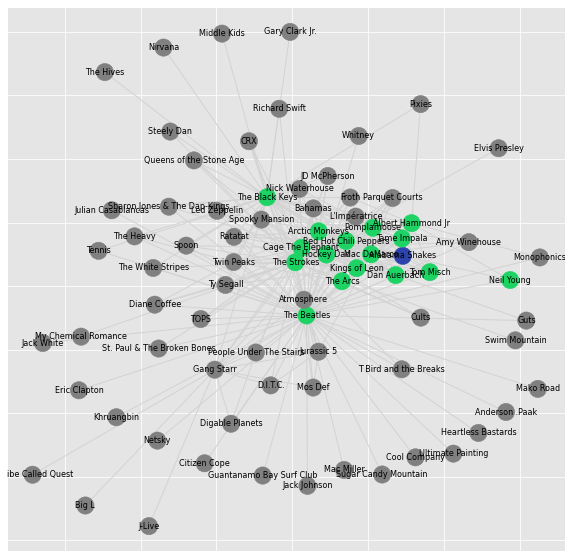

In [126]:
visualize_artist_recs('Alabama Shakes', f1_graph)

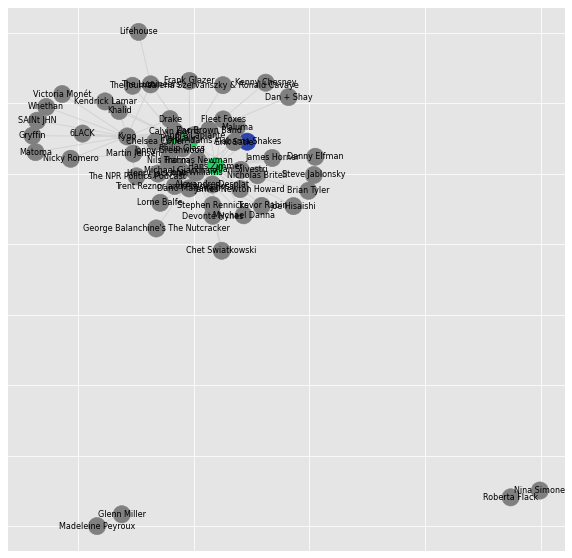

In [127]:
visualize_artist_recs('Alabama Shakes', f3_graph)

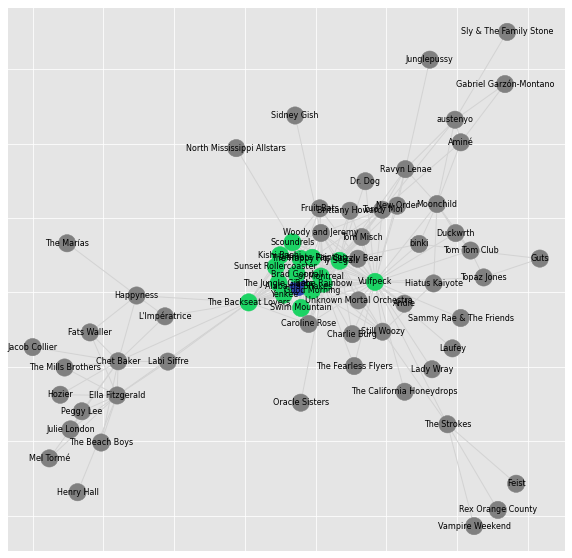

In [128]:
visualize_artist_recs('Alabama Shakes', user_graph)

In [136]:
def get_network_analytics(my_graph, g2, g3, g4, me, p2, p3,p4):
    d={}
    common_mins_played=[]
    for friend in [p2, p3, p4]:
        common_mins=sum(top_similar_artists(me, friend)['lowestCommonMinsPlayed'])
        common_mins_played.append(common_mins)
    d['avg_cluster_coefficient']=[nx.algorithms.cluster.average_clustering(my_graph),nx.algorithms.cluster.average_clustering(g2),nx.algorithms.cluster.average_clustering(g3),nx.algorithms.cluster.average_clustering(g4)]
    d['centrality']=[nx.algorithms.cluster.average_clustering(my_graph),nx.algorithms.cluster.average_clustering(g2),nx.algorithms.cluster.average_clustering(g3),nx.algorithms.cluster.average_clustering(g4)]

    #d['num_common_artists']=[]
    #d['shared_listening_minutes']
    #most_central_node=
    
    return d,common_mins_played

In [137]:
get_network_analytics(user_graph, f2_graph, f3_graph, f1_graph, user, f2, f3, f1, )[1]

[1609.6599333333331, 3094.4092666666643, 14667.421549999992]

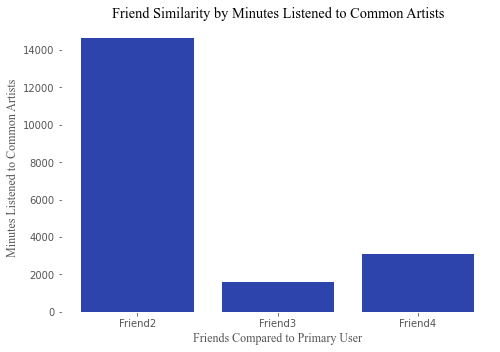

In [204]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
users = ['Friend2', 'Friend3',"Friend4"]
students = get_network_analytics(user_graph, f1_graph, f2_graph, f3_graph, user, f1, f2, f3)[1]
ax.bar(users,students, color='#2c44ac')
csfont = {'fontname':'Times New Roman'}
#ax.set_facecolor('black')
ax.set_facecolor('white')

plt.title('Friend Similarity by Minutes Listened to Common Artists',**csfont)
plt.xlabel("Friends Compared to Primary User", **csfont)
plt.ylabel('Minutes Listened to Common Artists',**csfont)


plt.show()

In [215]:
students


[14667.421549999992, 1609.6599333333331, 3094.4092666666643]

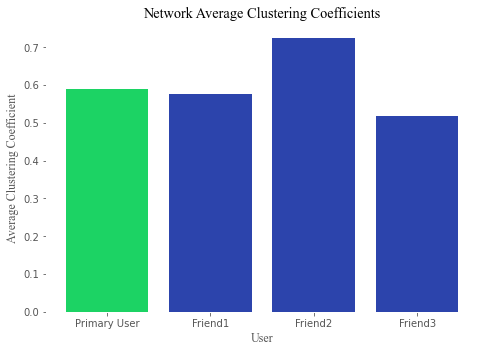

In [203]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
users = ['Primary User', 'Friend1', 'Friend2',"Friend3"]
students = get_network_analytics(user_graph,f1_graph, f2_graph, f3_graph ,user, f1, f2, f3 )[0]['avg_cluster_coefficient']
c = [ '#1cd364','#2c44ac','#2c44ac','#2c44ac',]

ax.bar(users,students, color=c)
csfont = {'fontname':'Times New Roman'}
plt.title('Network Average Clustering Coefficients',**csfont)
plt.xlabel("User", **csfont)
ax.set_facecolor('white')
plt.ylabel('Average Clustering Coefficient',**csfont)

plt.show()

In [140]:
top_similar_artists(user, f1)

,artistName,minsPlayeddf1,minsPlayeddf2,lowestCommonMinsPlayed
8,Tom Misch,312.346817,318.235900,312.346817
15,Alabama Shakes,249.688817,381.953817,249.688817
20,The Strokes,231.508250,593.930867,231.508250
5,Ty Segall,361.670050,168.129883,168.129883
28,Andie,161.231033,165.350717,161.231033
...,...,...,...,...
848,Club Kuru,0.558233,3.687767,0.558233
849,Waxahatchee,0.548367,4.270133,0.548367
81,Daniel Caesar,87.623450,0.529983,0.529983
850,Walker Lukens,0.526333,9.242933,0.526333


In [116]:
sum(top_similar_artists(user, f1)['lowestCommonMinsPlayed'])

nan

In [111]:
f1_graph

## Degree Shit

In [310]:
dic=nx.algorithms.centrality.degree_centrality(f1_graph)
lst=[(x, dic[x]) for x in dic.keys()] 
lst.sort(key=lambda x: x[1], reverse=True)
lst[:20]
avg=np.sum([x[1] for x in lst])/(len(lst))
avg

0.0941252839987017

In [311]:
dic=nx.algorithms.centrality.degree_centrality(user_graph)
lst=[(x, dic[x]) for x in dic.keys()] 
lst.sort(key=lambda x: x[1], reverse=True)
lst[:20]
avg=np.sum([x[1] for x in lst])/(len(lst))
avg

0.10528559249786869

In [312]:
dic=nx.algorithms.centrality.degree_centrality(f3_graph)
lst=[(x, dic[x]) for x in dic.keys()] 
lst.sort(key=lambda x: x[1], reverse=True)
lst[:20]
avg=np.sum([x[1] for x in lst])/(len(lst))
avg

0.09774011299435027

In [313]:
dic=nx.algorithms.centrality.degree_centrality(f2_graph)
lst=[(x, dic[x]) for x in dic.keys()] 
lst.sort(key=lambda x: x[1], reverse=True)
lst[:20]
avg=np.sum([x[1] for x in lst])/(len(lst))
avg

0.1599453178400547